In [15]:
#!pip install celluloid
from warnings import filterwarnings
filterwarnings("ignore")

from celluloid import Camera
import nibabel as nib
from IPython.display import HTML
from tqdm.notebook import tqdm
from pathlib import Path
import numpy as np
import cv2
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
zip_file = zipfile.ZipFile(file = "/content/drive/MyDrive/PyTorch_Vol3/08-3D-Liver-Tumor-Segmentation.zip",mode = "r")
zip_file.extractall()
zip_file.close()

In [111]:
zip_file = zipfile.ZipFile(file = "/content/drive/MyDrive/PyTorch_Vol3/07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation.zip",mode = "r")
zip_file.extractall()
zip_file.close()

In [7]:
root = Path("/content/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/imagesTr")
label = Path("/content/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/labelsTr")

In [8]:
def change_img_to_label_path(path):

    parts = list(path.parts)
    parts[parts.index("imagesTr")]="labelsTr"
    return Path(*parts)

In [9]:
sample_path = list(root.glob("liver*"))[0]
sample_path

PosixPath('/content/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/imagesTr/liver_5.nii.gz')

In [11]:
sample_path_label = change_img_to_label_path(sample_path)
sample_path, sample_path_label

(PosixPath('/content/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/imagesTr/liver_5.nii.gz'),
 PosixPath('/content/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/labelsTr/liver_5.nii.gz'))

In [12]:
ct = nib.load(sample_path).get_fdata()
mask = nib.load(sample_path_label).get_fdata().astype(int)

In [13]:
ct.shape,mask.shape

((248, 248, 144), (248, 248, 144))

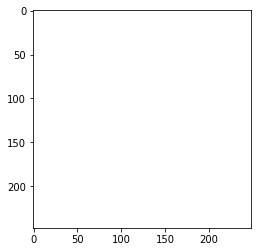

In [17]:
fig = plt.figure()
camera = Camera(fig)

for i in range(ct.shape[2]):
    plt.imshow(ct[:, :, i], cmap = "bone")
    mask_ = np.ma.masked_where(mask[:, :, i] == 0, mask[: , :, i])
    plt.imshow(mask_,alpha = 0.5)
    camera.snap()

animation = camera.animate()

In [18]:
HTML(animation.to_html5_video())

---

In [19]:
import torch

In [26]:
class DoubleConv(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv3d(in_channels, out_channels, 3, padding = 1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv3d(out_channels, out_channels, 3, padding = 1),
                                         torch.nn.ReLU())
        
    def forward(self,X):
        return self.step(X)

In [36]:
class UNet(torch.nn.Module):

    def __init__(self):
        super().__init__()

        self.layer1 = DoubleConv(1, 32)
        self.layer2 = DoubleConv(32, 64)
        self.layer3 = DoubleConv(64, 128)
        self.layer4 = DoubleConv(128, 256)

        self.layer5 = DoubleConv(256+128 , 128)
        self.layer6 = DoubleConv(128+64,64)
        self.layer7 = DoubleConv(64+32,32)
        self.layer8 = torch.nn.Conv3d(32,3,1)

        self.maxpool = torch.nn.MaxPool3d(2)

    def forward(self, x):

        x1 = self.layer1(x)
        x1m = self.maxpool(x1)

        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        x5 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x4)
        x5 = torch.cat([x5,x3],dim = 1)
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x5)
        x6 = torch.cat([x6,x2],dim = 1)
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x6)
        x7 = torch.cat([x7,x1],dim = 1)
        x7 = self.layer7(x7)

        ret = self.layer8(x7)

        return ret

In [37]:
model = UNet()

In [38]:
random_input = torch.randn(1,1,128,128,128)
output = model(random_input)
assert output.shape == torch.Size([1,3,128,128,128])

In [ ]:
model

In [52]:
layer1 = DoubleConv(1, 32)
layer2 = DoubleConv(32, 64)
layer3 = DoubleConv(64, 128)
layer4 = DoubleConv(128, 256)

layer5 = DoubleConv(256+128 , 128)
layer6 = DoubleConv(128+64,64)
layer7 = DoubleConv(64+32,32)
layer8 = torch.nn.Conv3d(32,3,1)

maxpool = torch.nn.MaxPool3d(2)

In [53]:
x1 =  layer1(random_input)
x1m = maxpool(x1)

x2 = layer2(x1m)
x2m = maxpool(x2)

x3 = layer3(x2m)
x3m = maxpool(x3)

x4 = layer4(x3m)

x5 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x4)
x5 = torch.cat([x5,x3],dim = 1)
x5 = layer5(x5)

x6 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x5)
x6 = torch.cat([x6,x2],dim = 1)
x6 = layer6(x6)

x7 = torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x6)
x7 = torch.cat([x7,x1],dim = 1)
x7 = layer7(x7)

ret = layer8(x7)

In [51]:
shape = [random_input.shape , x1.shape, x1m.shape, x2.shape,x2m.shape,x3.shape,x3m.shape,x4.shape]
for i in shape:
    print(i)

torch.Size([1, 1, 128, 128, 128])
torch.Size([1, 32, 128, 128, 128])
torch.Size([1, 32, 64, 64, 64])
torch.Size([1, 64, 64, 64, 64])
torch.Size([1, 64, 32, 32, 32])
torch.Size([1, 128, 32, 32, 32])
torch.Size([1, 128, 16, 16, 16])
torch.Size([1, 256, 16, 16, 16])


In [57]:
# Farka bakmak için !!!
# Tek Tek bakıyoruz !!!
torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x4).shape

torch.Size([1, 256, 32, 32, 32])

In [59]:
torch.cat([torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x4), x3],dim=1).shape

torch.Size([1, 384, 32, 32, 32])

In [61]:
layer5(torch.cat([torch.nn.Upsample(scale_factor = 2,mode = "trilinear")(x4), x3],dim=1)).shape

torch.Size([1, 128, 32, 32, 32])

In [54]:
shape2 = [x5.shape, x6.shape, x7.shape,ret.shape]
for i in shape2:
    print(i)

torch.Size([1, 128, 32, 32, 32])
torch.Size([1, 64, 64, 64, 64])
torch.Size([1, 32, 128, 128, 128])
torch.Size([1, 3, 128, 128, 128])


---

In [66]:
#!pip install pytorch-lightning
#!pip install torchmetrics  
#!pip install torchio

In [68]:
import torchio as tio
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [74]:
path = Path("/content/08-3D-Liver-Tumor-Segmentation/Task03_Liver_rs/imagesTr")
subject_paths = list(path.glob("liver_*"))
subjects = []

for subject_path in subject_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"CT":tio.ScalarImage(subject_path), "Label" : tio.LabelMap(label_path)})
    subjects.append(subject)

In [76]:
len(subjects)

123

In [77]:
for subject in subjects:
    assert subject["CT"].orientation == ("R", "A", "S")

In [81]:
process = tio.Compose([
                       tio.CropOrPad((256,256,200)),
                       tio.RescaleIntensity((-1,1))
])

augmentation = tio.RandomAffine(scales = (0.9,1.1), degrees =(-10,10))

val_transform = process
train_transform = tio.Compose([process, augmentation])

In [83]:
train_dataset = tio.SubjectsDataset(subjects[:105], transform = train_transform)
val_dataset = tio.SubjectsDataset(subjects[105:], transform = val_transform)

sampler = tio.data.LabelSampler(patch_size = 96, label_name = "Label", label_probabilities={0:0.2, 1:0.3, 2:0.5})

In [87]:
train_pathces_queue = tio.Queue(
    train_dataset,
    max_length=40,
    samples_per_volume = 5,
    sampler = sampler,
    num_workers = 4)

val_pathces_queue = tio.Queue(
    val_dataset,
    max_length=40,
    samples_per_volume = 5,
    sampler = sampler,
    num_workers = 4)

In [88]:
train_loader = torch.utils.data.DataLoader(train_pathces_queue, batch_size = 2, num_workers = 0)
val_loader = torch.utils.data.DataLoader(val_pathces_queue, batch_size = 2, num_workers = 0)

---

In [89]:
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, data):
        return self.model(data)

    def training_step(self,batch,batch_idx):
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]
        mask = mask.long()

        pred = self(img)
        loss = self.loss_fn(pred,mask)
        self.log("Train Loss",loss)
        return loss

    def validation_step(self,batch,batch_idx):
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]
        mask = mask.long()

        pred = self(img)
        loss = self.loss_fn(pred,mask)
        self.log("Val Loss",loss)
        return loss

    def configure_optimizers(self):
        return [self.optimizer]

In [90]:
model = Segmenter()

In [93]:
checkpoint_callback = ModelCheckpoint(
    monitor = "Val Loss",
    save_top_k = 10,
    mode = "min"
)

In [94]:
gpus = 0
trainer = pl.Trainer(gpus = gpus, logger = TensorBoardLogger(save_dir = "./logs"), log_every_n_steps=1,
                     callbacks = checkpoint_callback, max_epochs = 100 )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [95]:
trainer.fit(model, train_loader, val_loader)

Missing logger folder: ./logs/default

  | Name    | Type             | Params
---------------------------------------------
0 | model   | UNet             | 5.8 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.344    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

---

In [ ]:
model = Segmenter.load_from_checkpoint("/content/08-3D-Liver-Tumor-Segmentation/weights/epoch=97-step=25773.ckpt")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.eval();
model.to(device)

In [97]:
IDX = 4
imgs = val_dataset[IDX]["CT"]["data"]
mask = val_dataset[IDX]["Label"]["data"]

In [98]:
grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8,8,8))

In [99]:
aggreator = tio.inference.GridAggregator(grid_sampler)

In [100]:
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size = 4)

In [102]:
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch["CT"]["data"].to(device)
        locations = patches_batch[tio.LOCATION]
        pred = model(input_tensor)
        aggreator.add_batch(pred, locations)

In [103]:
output_tensor = aggreator.get_output_tensor()

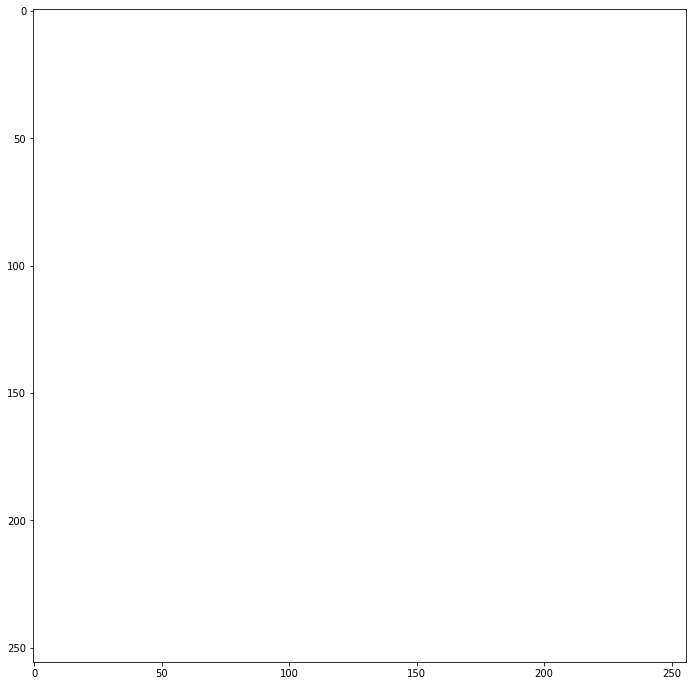

In [109]:
fig = plt.figure(figsize = (12,12))
camera = Camera(fig)
pred = output_tensor.argmax(0)

for i in range(0 , output_tensor.shape[-1], 2):

    plt.imshow(imgs[0, :, : ,i], cmap = "bone")
    mask_ = np.ma.masked_where(pred[:, :, i] == 0, pred[:, :, i])
    plt.imshow(mask_, alpha = 0.5, cmap = "autumn")
    camera.snap()
animation = camera.animate()

In [110]:
HTML(animation.to_html5_video())